# 🤪 GANs on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own GAN on the CelebA faces dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU, UpSampling2D, ReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
VALIDATION_SPLIT = 0.2
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
train_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [5]:
# Preprocess the data
def preprocess(img):
    """
    Normalize the images
    """
    img = tf.cast(img, "float32") / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

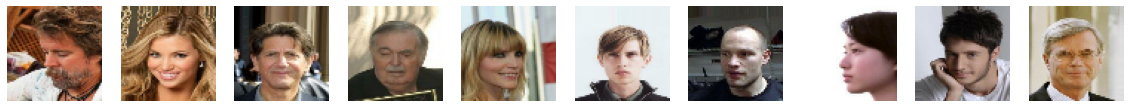

In [6]:
# Show some faces from the training set
display(np.array(list(train.take(1).get_single_element())), cmap = None)

## 2. Build the GAN <a name="build"></a>

In [31]:
discriminator_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(x)
x = LeakyReLU()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=2, padding="same")(x)
x = LeakyReLU()(x)
x = Flatten()(x)
discriminator_output = Dense(1)(x)

discriminator = Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        102464    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)          102464    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 64)          0   

In [23]:
generator_input = Input(shape=(Z_DIM,))
x = Dense(4*4*NUM_FEATURES)(generator_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Reshape((4, 4, NUM_FEATURES))(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=5, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
generator_output = Conv2D(CHANNELS, kernel_size=5, padding="same", activation="tanh")(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              205824    
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 8, 8, 64)         0         
 2D)                                                       

In [53]:
class WGAN(Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps, gp_weight):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def d_loss_fun(self, real_predictions, fake_predictions):
        real_loss = tf.reduce_mean(real_predictions)
        fake_loss = tf.reduce_mean(fake_predictions)
        return fake_loss - real_loss
    
    def g_loss_fn(self, fake_predictions):
        return -tf.reduce_mean(fake_predictions)

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            # Train the discriminator on fake images
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training = True)
                fake_predictions = self.discriminator(fake_images, training = True)
                real_predictions = self.discriminator(real_images, training = True)
                
                d_cost = self.d_loss_fun(real_predictions, fake_predictions)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
                
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [54]:
# Create a GAN
wgan = WGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM
           , discriminator_extra_steps = 3, gp_weight = 10.0)

## 3. Train the GAN <a name="train"></a>

In [55]:
# Compile the GAN
wgan.compile(
    d_optimizer=Adam(learning_rate=0.0002),
    g_optimizer=Adam(learning_rate=0.0002),
)

In [56]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs2")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        

In [57]:
history = wgan.fit(
    train, 
    epochs=EPOCHS*10, 
    # steps_per_epoch = 100, 
    # initial_epoch = 270,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

Epoch 1/100
   4/1267 [..............................] - ETA: 2:49:17 - d_loss: 5.3082 - g_loss: 1.1772

KeyboardInterrupt: 

In [30]:
# Save the final models
generator.save("./models/encoder")
discriminator.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/encoder/assets
INFO:tensorflow:Assets written to: ./models/decoder/assets
